In [1]:
import osmnx as ox
import srtm
import matplotlib.pyplot as plt
import matplotlib.cm as cm




In [6]:
address = "Rue Defacqz, Brussels, Belgium"
location_point = ox.geocode(address)
print("Coordinates:", location_point) 

distance = 1000  # meters

Coordinates: (50.8286581, 4.3612305)


In [7]:
# network_type {“all”, “all_public”, “bike”, “drive”, “drive_service”, “walk”}
# dist -> bounding box of size 2*dist around the point (a square)
G = ox.graph_from_point(location_point, dist=distance, network_type='walk')

In [8]:
elevation_data = srtm.get_data()
for node, data in G.nodes(data=True):
    lat = data['y']
    lon = data['x']
    elev = elevation_data.get_elevation(lat, lon)
    data['elevation'] = elev if elev is not None else 0

edge_elevations = []
for u, v, data in G.edges(data=True):
    elev_u = G.nodes[u].get('elevation', 0)
    elev_v = G.nodes[v].get('elevation', 0)
    data['elevation_gain'] = elev_v - elev_u
    edge_elevations.append(data['elevation_gain'])

/var/folders/j6/q1ym8vy96dv41788r8s4d0jw0000gn/T/ipykernel_39459/2099079022.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('terrain')


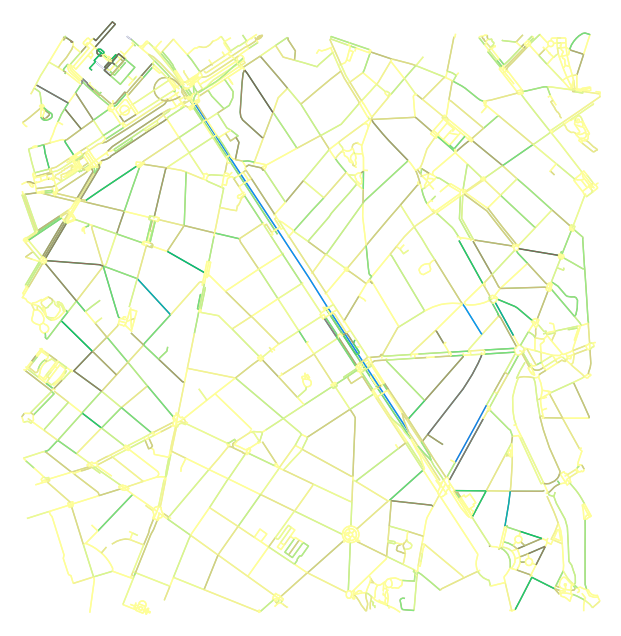

In [9]:


# Normalize edge elevations for colormap
norm = plt.Normalize(vmin=min(edge_elevations), vmax=max(edge_elevations))
cmap = cm.get_cmap('terrain')
edge_colors = cmap(norm(edge_elevations))

fig, ax = ox.plot_graph(
    G,
    figsize=(8,8),
    node_size=0,
    node_color='blue',
    edge_color=edge_colors,
    edge_linewidth=1,
    bgcolor='white',
)